In [1]:
import re
import scipy
from numpy import random
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf 
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Activation, Dense

from sklearn.svm import LinearSVC
from sklearn import preprocessing,svm
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, log_loss, precision_recall_fscore_support

Using TensorFlow backend.


### Read Files

In [2]:
train_df=pd.read_csv('UNSW_2018_IoT_Botnet_Final_10_best_Training.csv')
test_df=pd.read_csv('UNSW_2018_IoT_Botnet_Final_10_best_Testing.csv')

In [3]:
train_df

,pkSeqID,proto,saddr,sport,daddr,dport,seq,stddev,N_IN_Conn_P_SrcIP,min,state_number,mean,N_IN_Conn_P_DstIP,drate,srate,max,attack,category,subcategory
0,3142762,udp,192.168.100.150,6551,192.168.100.3,80,251984,1.900363,100,0.000000,4,2.687519,100,0.000000,0.494549,4.031619,1,DDoS,UDP
1,2432264,tcp,192.168.100.150,5532,192.168.100.3,80,256724,0.078003,38,3.856930,3,3.934927,100,0.000000,0.256493,4.012924,1,DDoS,TCP
2,1976315,tcp,192.168.100.147,27165,192.168.100.3,80,62921,0.268666,100,2.974100,3,3.341429,100,0.000000,0.294880,3.609205,1,DDoS,TCP
3,1240757,udp,192.168.100.150,48719,192.168.100.3,80,99168,1.823185,63,0.000000,4,3.222832,63,0.000000,0.461435,4.942302,1,DoS,UDP
4,3257991,udp,192.168.100.147,22461,192.168.100.3,80,105063,0.822418,100,2.979995,4,3.983222,100,0.000000,1.002999,4.994452,1,DDoS,UDP
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2934812,1132803,udp,192.168.100.149,56044,192.168.100.5,80,253370,0.016992,100,4.082509,4,4.102515,100,0.000000,0.243473,4.124047,1,DoS,UDP
2934813,3384621,udp,192.168.100.150,21546,192.168.100.3,80,231693,1.922317,100,0.000000,4,2.718527,100,0.000000,0.490800,4.090534,1,DDoS,UDP
2934814,775893,udp,192.168.100.149,30897,192.168.100.5,80,158616,2.112228,100,0.000000,4,2.110766,100,0.000000,0.207444,4.332615,1,DoS,UDP
2934815,443484,tcp,192.168.100.147,36904,192.168.100.7,80,179855,0.000000,100,0.000000,3,0.000000,100,0.000000,0.162130,0.000000,1,DoS,TCP


In [4]:
test_df

,pkSeqID,proto,saddr,sport,daddr,dport,seq,stddev,N_IN_Conn_P_SrcIP,min,state_number,mean,N_IN_Conn_P_DstIP,drate,srate,max,attack,category,subcategory
0,792371,udp,192.168.100.150,48516,192.168.100.3,80,175094,0.226784,100,4.100436,4,4.457383,100,0.000000,0.404711,4.719438,1,DoS,UDP
1,2056418,tcp,192.168.100.148,22267,192.168.100.3,80,143024,0.451998,100,3.439257,1,3.806172,100,0.225077,0.401397,4.442930,1,DDoS,TCP
2,2795650,udp,192.168.100.149,28629,192.168.100.3,80,167033,1.931553,73,0.000000,4,2.731204,100,0.000000,0.407287,4.138455,1,DDoS,UDP
3,2118009,tcp,192.168.100.148,42142,192.168.100.3,80,204615,0.428798,56,3.271411,1,3.626428,100,0.000000,0.343654,4.229700,1,DDoS,TCP
4,303688,tcp,192.168.100.149,1645,192.168.100.5,80,40058,2.058381,100,0.000000,3,1.188407,100,0.000000,0.135842,4.753628,1,DoS,TCP
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
733700,1571905,udp,192.168.100.148,17412,192.168.100.6,80,168162,1.743940,39,0.000000,4,3.020449,39,0.000000,0.224603,4.043432,1,DoS,UDP
733701,2787099,udp,192.168.100.147,932,192.168.100.3,80,158482,0.694618,65,3.002272,4,3.905409,100,0.000000,0.875121,4.691634,1,DDoS,UDP
733702,2255382,tcp,192.168.100.149,47980,192.168.100.3,80,79841,1.744651,53,0.000000,1,2.464288,100,0.278496,0.472773,3.802142,1,DDoS,TCP
733703,588946,tcp,192.168.100.147,25096,192.168.100.7,80,63165,0.000000,100,0.000000,3,0.000000,100,0.000000,0.070461,0.000000,1,DoS,TCP


In [5]:
main_df=pd.concat([train_df,test_df])

In [6]:
main_df

,pkSeqID,proto,saddr,sport,daddr,dport,seq,stddev,N_IN_Conn_P_SrcIP,min,state_number,mean,N_IN_Conn_P_DstIP,drate,srate,max,attack,category,subcategory
0,3142762,udp,192.168.100.150,6551,192.168.100.3,80,251984,1.900363,100,0.000000,4,2.687519,100,0.000000,0.494549,4.031619,1,DDoS,UDP
1,2432264,tcp,192.168.100.150,5532,192.168.100.3,80,256724,0.078003,38,3.856930,3,3.934927,100,0.000000,0.256493,4.012924,1,DDoS,TCP
2,1976315,tcp,192.168.100.147,27165,192.168.100.3,80,62921,0.268666,100,2.974100,3,3.341429,100,0.000000,0.294880,3.609205,1,DDoS,TCP
3,1240757,udp,192.168.100.150,48719,192.168.100.3,80,99168,1.823185,63,0.000000,4,3.222832,63,0.000000,0.461435,4.942302,1,DoS,UDP
4,3257991,udp,192.168.100.147,22461,192.168.100.3,80,105063,0.822418,100,2.979995,4,3.983222,100,0.000000,1.002999,4.994452,1,DDoS,UDP
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
733700,1571905,udp,192.168.100.148,17412,192.168.100.6,80,168162,1.743940,39,0.000000,4,3.020449,39,0.000000,0.224603,4.043432,1,DoS,UDP
733701,2787099,udp,192.168.100.147,932,192.168.100.3,80,158482,0.694618,65,3.002272,4,3.905409,100,0.000000,0.875121,4.691634,1,DDoS,UDP
733702,2255382,tcp,192.168.100.149,47980,192.168.100.3,80,79841,1.744651,53,0.000000,1,2.464288,100,0.278496,0.472773,3.802142,1,DDoS,TCP
733703,588946,tcp,192.168.100.147,25096,192.168.100.7,80,63165,0.000000,100,0.000000,3,0.000000,100,0.000000,0.070461,0.000000,1,DoS,TCP


In [7]:
main_df.columns

Index(['pkSeqID', 'proto', 'saddr', 'sport', 'daddr', 'dport', 'seq', 'stddev',
       'N_IN_Conn_P_SrcIP', 'min', 'state_number', 'mean', 'N_IN_Conn_P_DstIP',
       'drate', 'srate', 'max', 'attack', 'category', 'subcategory'],
      dtype='object')

### select columns

In [8]:
ndf=main_df[['seq', 'stddev',
       'N_IN_Conn_P_SrcIP', 'min', 'state_number', 'mean', 'N_IN_Conn_P_DstIP',
       'drate', 'srate', 'max','attack', 'category']]

### Extract features & class 

In [16]:
X=ndf.iloc[:,:-2]
y=ndf.iloc[:,-2]

### Initialize Model

In [11]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

clf = RandomForestClassifier(n_estimators=20, random_state=0)

# scores = cross_val_score(clf, X, y, cv=4)
# print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

### Train Model

In [12]:

from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

y_pred = cross_val_predict(clf, X, y, cv=4)
conf_mat = confusion_matrix(y, y_pred)

### Confusion Metrix

Confusion matrix, without normalization


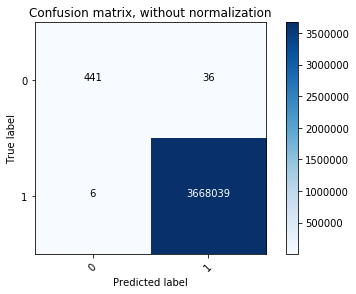

In [13]:
import itertools
def generate_confusion_matrix(cnf_matrix, classes, normalize=False, title='Confusion matrix'):
    if normalize:
        cnf_matrix = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cnf_matrix, interpolation='nearest', cmap=plt.get_cmap('Blues'))
    plt.title(title)
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cnf_matrix.max() / 2.

    for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
        plt.text(j, i, format(cnf_matrix[i, j], fmt), horizontalalignment="center",
                 color="white" if cnf_matrix[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    return cnf_matrix


class_names = ['0', '1']
plt.figure()
generate_confusion_matrix(conf_mat, classes=class_names, title='Confusion matrix, without normalization')
plt.show()

### save model

In [17]:
import joblib
model = RandomForestClassifier(n_estimators=20, random_state=0)
model.fit(X,y)
joblib.dump(clf, "./trained_RF_model.joblib")

['./trained_RF_model.joblib']

In [18]:
import pickle

filename = 'trained_RF_model.sav'
pickle.dump(model, open(filename, 'wb'))